In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import seaborn as sns

sns.set()
%matplotlib inline

In [3]:
# load data from file to existing envrionment
def load_data(filepath,format='csv'):
    if format == 'csv':
        return pd.read_csv(filepath)
    elif format == 'xlsx':
        return pd.read_excel(filepath)

In [4]:
df_raw = load_data("WA_Fn-UseC_-Telco-Customer-Churn.csv","csv")
df_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# Rename column names and map values for numeric calculation
def clean_data(df):
    df.rename(columns={'gender':'Gender'
                       ,'customerID':'CustomerID'
                       ,'Contract':'ContractType'
                       ,'InternetService':'InternetServiceType'
                       ,'tenure':'Tenure'
                      }
              ,inplace=True)


    df['Partner'] = df.Partner.map({'Yes':1,'No':0})
    df['Dependents'] = df.Dependents.map({'Yes':1,'No':0})

    df['PhoneService'] = df.PhoneService.map({'Yes':1,'No':0})
    df['MultipleLines'] = df.MultipleLines.map({'Yes':1,'No':0,'No phone service':0})

    df['InternetService'] = df.InternetServiceType.map({'DSL':1,'Fiber optic':1,'No':0})
    df['OnlineSecurity'] = df.OnlineSecurity.map({'Yes':1,'No':0,'No internet service':0})
    df['OnlineBackup'] = df.OnlineBackup.map({'Yes':1,'No':0,'No internet service':0})
    df['DeviceProtection'] = df.DeviceProtection.map({'Yes':1,'No':0,'No internet service':0})
    df['TechSupport'] = df.TechSupport.map({'Yes':1,'No':0,'No internet service':0})
    df['StreamingTV'] = df.StreamingTV.map({'Yes':1,'No':0,'No internet service':0})
    df['StreamingMovies'] = df.StreamingMovies.map({'Yes':1,'No':0,'No internet service':0})

    df['IsContracted'] = df.ContractType.map({'One year':1,'Two year':1,'Month-to-month':0})
    df['PaperlessBilling'] = df.PaperlessBilling.map({'Yes':1,'No':0})
    df['Churn'] = df.Churn.map({'Yes':1,'No':0})
    
    df.loc[df['TotalCharges']==' ','TotalCharges'] = np.nan
    df['TotalCharges'] = df['TotalCharges'].astype('float64')
    df.loc[df['TotalCharges']==np.nan,'TotalCharges'] = df['MonthlyCharges'] * df['Tenure']
    
    return df

In [9]:
# clean, shuffle and reindexing traing data set -- shuffling may improve cross validation accuracy
clean_df = shuffle(clean_data(df_raw.copy())).reset_index()
clean_df.head()

,index,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetServiceType,...,StreamingTV,StreamingMovies,ContractType,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService,IsContracted
0,5480,2275-RBYQS,Female,0,0,0,1,1,0,DSL,...,0,0,Month-to-month,1,Mailed check,45.40,45.40,0,1,0
1,5656,7312-XSBAT,Male,0,0,0,1,1,0,DSL,...,0,0,Month-to-month,0,Electronic check,49.75,49.75,0,1,0
2,1107,0971-QIFJK,Female,0,1,0,69,1,1,No,...,0,0,Two year,0,Bank transfer (automatic),24.25,1641.80,0,0,1
3,2234,4500-HKANN,Male,0,1,1,23,1,1,DSL,...,0,0,Two year,0,Mailed check,59.70,1414.20,0,1,1
4,546,6986-IJDHX,Male,0,1,1,39,1,0,Fiber optic,...,1,0,Month-to-month,1,Mailed check,86.30,3266.00,1,1,0


In [10]:
# define variables

categorical_vars = ['Gender','InternetServiceType','PaymentMethod','ContractType']
binary_vars = ['SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup'
               ,'DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies','PaperlessBilling','InternetService'
               , 'IsContracted']
numeric_vars = ['Tenure','MonthlyCharges']
target_var = 'Churn'

In [11]:
# encode categorical data to numeric using One-hot encoding method
def one_hot_encoding_features_df(df, cat_feat):
    cat_df = pd.get_dummies(df[cat_feat])
    return cat_df


In [320]:
# merge categorical, numerical, and binary data
def merge_df(categorical=None,binary=None,numerical=None):
    return pd.concat([categorical,binary,numerical],axis = 1)


In [13]:
feature_df = merge_df(one_hot_encoding_features_df(clean_df,categorical_vars), clean_df[binary_vars] ,clean_df[numeric_vars])
target_df = clean_df[target_var]

In [14]:
def train_test_split_fn(feature, target , test_size=None, random_state=0):
    return train_test_split(feature, target, test_size = test_size,random_state = random_state )

In [53]:
x_train, x_test, y_train , y_test = train_test_split_fn(feature_df,target_df,0.2,42)

In [54]:
RF_model = RandomForestClassifier(oob_score = True, random_state = 42)

In [55]:
RF_model.fit(x_train,y_train)

print("OOB score", RF_model.oob_score_)

OOB score 0.7575434859779908


D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [66]:
rf_result = cross_val_score(RF_model, x_train, y_train, scoring = 'accuracy')
print(rf_result.mean())

0.7712092366500061


D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob esti

In [56]:
predicted = np.argmax(RF_model.oob_decision_function_, axis = 1)
metrics.roc_auc_score(y_train, predicted)

0.6498591393511952

In [59]:
x_train_sm , y_train_sm = SMOTE(random_state = 42, ratio = 1.0).fit_sample(x_train,y_train)

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [60]:
RF_model_1 = RandomForestClassifier(oob_score = True, random_state = 42)

In [61]:
RF_model_1.fit(x_train_sm, y_train_sm)

print("OOB score", RF_model_1.oob_score_)

OOB score 0.8216177178623014


D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [67]:
rf_result_1 = cross_val_score(RF_model_1, x_train_sm, y_train_sm, scoring = 'accuracy')
print(rf_result_1.mean())

0.8134560005008242


D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob esti

In [70]:
predicted_1 = np.argmax(RF_model_1.oob_decision_function_, axis = 1)
metrics.roc_auc_score(y_train, predicted)

0.6498591393511952

### Max depth size

D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob esti

Max depth size 1
Train AUC ROC score  0.7764805007221953
Test AUC ROC score  0.733056101618025
Max depth size 2
Train AUC ROC score  0.784063553201733
Test AUC ROC score  0.7360943091889712


D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Max depth size 3
Train AUC ROC score  0.7882763601348098
Test AUC ROC score  0.7424013307122334
Max depth size 4
Train AUC ROC score  0.8094607607125661
Test AUC ROC score  0.7497542718887041


D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Max depth size 5
Train AUC ROC score  0.8249879634087626
Test AUC ROC score  0.7522392761731942
Max depth size 7
Train AUC ROC score  0.8444872412132883
Test AUC ROC score  0.755245980140128


D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Max depth size 10
Train AUC ROC score  0.8873375060182958
Test AUC ROC score  0.7468811432027823


D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Max depth size 15
Train AUC ROC score  0.9512518054886857
Test AUC ROC score  0.7262614043046525
Max depth size 20
Train AUC ROC score  0.9773712084737602
Test AUC ROC score  0.681590553959373


D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


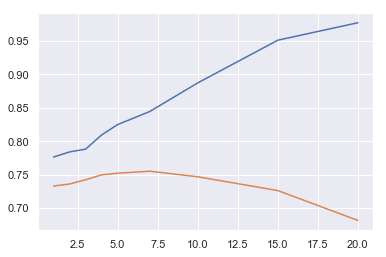

In [524]:
max_depth_size = [1,2,3,4,5,7,10,15,20]
train_roc_score = []
test_roc_score = []

for depth in max_depth_size:
    model = RandomForestClassifier(oob_score = True, random_state = 42, max_depth = depth)
    model.fit(x_train_sm, y_train_sm)
    train_pred = model.predict(x_train_sm)
    test_pred = model.predict(x_test)
    roc_auc_train = metrics.roc_auc_score(y_train_sm, train_pred)
    roc_auc_test = metrics.roc_auc_score(y_test, test_pred)
    train_roc_score.append(roc_auc_train)
    test_roc_score.append(roc_auc_test)
    print("Max depth size", depth)
    print("Train AUC ROC score ", roc_auc_train)
    print("Test AUC ROC score ", roc_auc_test)


plt.plot(max_depth_size, train_roc_score)
plt.plot(max_depth_size, test_roc_score)

### n_estimator

D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob esti

No of trees 1
Train AUC ROC Score 0.7975445353875782
Test AUC ROC Score 0.7127098140027219
No of trees 5
Train AUC ROC Score 0.8229417428984113
Test AUC ROC Score 0.754613387771561
No of trees 10
Train AUC ROC Score 0.8249879634087626
Test AUC ROC Score 0.7522392761731942


D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


No of trees 20
Train AUC ROC Score 0.8260712566201253
Test AUC ROC Score 0.7527836584505269
No of trees 50
Train AUC ROC Score 0.8255897929706306
Test AUC ROC Score 0.7509967740309491
No of trees 70
Train AUC ROC Score 0.8231824747231583
Test AUC ROC Score 0.7525215484651444
No of trees 100
Train AUC ROC Score 0.8230621088107848
Test AUC ROC Score 0.7531314582388225
No of trees 150
Train AUC ROC Score 0.8225806451612905
Test AUC ROC Score 0.7511706739250971
No of trees 200
Train AUC ROC Score 0.8229417428984112
Test AUC ROC Score 0.7500050405766421
No of trees 500
Train AUC ROC Score 0.8231824747231583
Test AUC ROC Score 0.7521510660819599
No of trees 1000
Train AUC ROC Score 0.8245064997592682
Test AUC ROC Score 0.7534364131256617


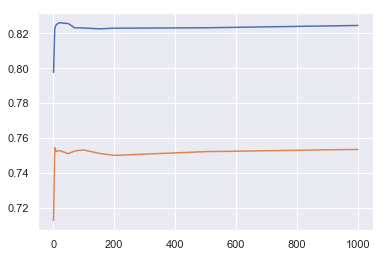

In [95]:
n_estimator_size = [1,5,10,20,50,70,100,150,200,500,1000]
train_roc_score = []
test_roc_score = []


for estimator in n_estimator_size:
    model = RandomForestClassifier(estimator, random_state = 42, oob_score = True, max_depth = 5)
    model.fit(x_train_sm, y_train_sm)
    train_pred = model.predict(x_train_sm)
    test_pred = model.predict(x_test)
    roc_auc_train = metrics.roc_auc_score(y_train_sm, train_pred)
    roc_auc_test = metrics.roc_auc_score(y_test, test_pred)
    train_roc_score.append(roc_auc_train)
    test_roc_score.append(roc_auc_test)
    print("No of trees", estimator)
    print("Train AUC ROC Score", roc_auc_train)
    print("Test AUC ROC Score", roc_auc_test)

plt.plot(n_estimator_size, train_roc_score)
plt.plot(n_estimator_size, test_roc_score)

### Max features

In [119]:
max_features = ['auto', None, 'sqrt','log2',0.7,0.2]
oob_score = []

for feature in max_features:
    model = RandomForestClassifier( n_estimators = 200, oob_score = True, random_state = 42 ,  max_depth = 5, max_features = feature)
    model.fit(x_train_sm, y_train_sm)
    oob_score.append(model.oob_score_)
    print("Max features", feature)
    print("OOB Score", model.oob_score_)



Max features auto
OOB Score 0.8155994222436206
Max features None
OOB Score 0.8201733269138181
Max features sqrt
OOB Score 0.8155994222436206
Max features log2
OOB Score 0.8134328358208955
Max features 0.7
OOB Score 0.8231824747231584
Max features 0.2
OOB Score 0.8155994222436206


### Min Sample Leaf 

min_sample_leaf 1
OOB Score 0.8155994222436206
min_sample_leaf 2
OOB Score 0.8151179585941262
min_sample_leaf 3
OOB Score 0.815479056331247
min_sample_leaf 4
OOB Score 0.8140346653827636
min_sample_leaf 5
OOB Score 0.8142753972075109
min_sample_leaf 10
OOB Score 0.8136735676456428
min_sample_leaf 15
OOB Score 0.8128310062590275
min_sample_leaf 20
OOB Score 0.8112662493981705
min_sample_leaf 50
OOB Score 0.8070534424650939


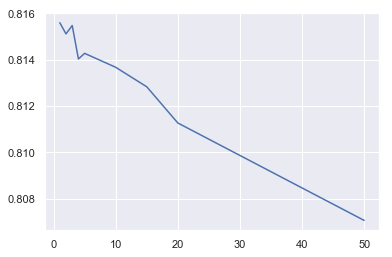

In [127]:
min_sample_leaf = [1,2,3,4,5,10,15,20,50]
oob_score = []

for sample in min_sample_leaf:
    model = RandomForestClassifier(n_estimators = 200, oob_score = True, random_state = 42, max_depth = 5, min_samples_leaf = sample
                                  , max_features = 'auto')
    model.fit(x_train_sm, y_train_sm)
    oob_score.append(model.oob_score_)
    print("min_sample_leaf", sample)
    print("OOB Score", model.oob_score_)

plt.plot(min_sample_leaf, oob_score)


In [346]:
RF_model_final = RandomForestClassifier(n_estimators = 5, random_state = 42, max_depth = 5)
RF_model_final.fit(x_train_sm,y_train_sm)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [347]:
RF_model_final.estimators_

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=1608637542, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=1273642419, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_frac

In [350]:
# Confusion matrix
predicted = RF_model_final.predict(x_test)
metrics.confusion_matrix(y_test,predicted)


array([[779, 241],
       [ 99, 290]], dtype=int64)

In [351]:
# Confusion matrix
metrics.confusion_matrix(y_test,predicted)

array([[779, 241],
       [ 99, 290]], dtype=int64)

In [352]:
# Classification report

print(metrics.classification_report(y_test,predicted))

             precision    recall  f1-score   support

          0       0.89      0.76      0.82      1020
          1       0.55      0.75      0.63       389

avg / total       0.79      0.76      0.77      1409



In [353]:
metrics.roc_auc_score(y_test,predicted)

0.754613387771561

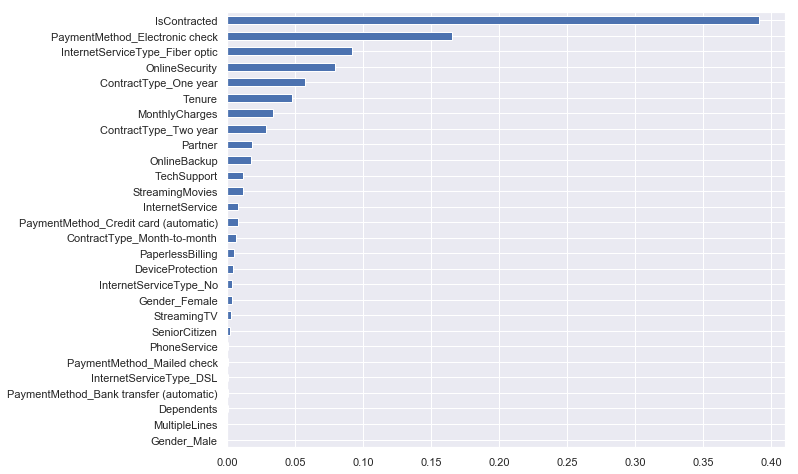

In [354]:
feature_importances = pd.Series(RF_model_final.feature_importances_,index = x_train.columns)
plt.figure(figsize=(10,8))
feature_importances.sort_values().plot(kind='barh')

In [609]:
selected_features = clean_df[['PaymentMethod','ContractType','InternetServiceType','OnlineSecurity','Tenure','MonthlyCharges','Churn']].copy()
selected_features['Payment_Electronic_Check'] = clean_df.PaymentMethod.map({'Electronic check':1,'Credit card (automatic)':0
                                                                            ,'Bank transfer (automatic)':0,'Mailed check':0 })
selected_features['Internet_Fiber_Optic'] = clean_df.InternetServiceType.map({'Fiber optic':1,'DSL':0
                                                                            ,'No':0})
selected_features.head()

,PaymentMethod,ContractType,InternetServiceType,OnlineSecurity,Tenure,MonthlyCharges,Churn,Payment_Electronic_Check,Internet_Fiber_Optic
0,Mailed check,Month-to-month,DSL,0,1,45.40,0,0,0
1,Electronic check,Month-to-month,DSL,1,1,49.75,0,1,0
2,Bank transfer (automatic),Two year,No,0,69,24.25,0,0,0
3,Mailed check,Two year,DSL,0,23,59.70,0,0,0
4,Mailed check,Month-to-month,Fiber optic,0,39,86.30,1,0,1


In [611]:
selected_feature_df = merge_df(one_hot_encoding_features_df(selected_features,['ContractType']),selected_features[['Payment_Electronic_Check','Internet_Fiber_Optic','OnlineSecurity']], numerical = selected_features[['Tenure','MonthlyCharges']])
selected_target_df = clean_df[target_var]

In [612]:
feat_x_train, feat_x_test, feat_y_train , feat_y_test = train_test_split_fn(selected_feature_df,selected_target_df,0.2,42)
feat_x_train_sm , feat_y_train_sm = SMOTE(random_state = 42, ratio = 1.0).fit_sample(feat_x_train,feat_y_train)

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [613]:
RF_model_final = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_depth = 7,class_weight = 'balanced')
RF_model_final.fit(feat_x_train,feat_y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [614]:
predicted = RF_model_final.predict(feat_x_test)

In [615]:
# Confusion matrix
metrics.confusion_matrix(feat_y_test,predicted)

array([[763, 257],
       [ 77, 312]], dtype=int64)

In [616]:
# Classification report

print(metrics.classification_report(feat_y_test,predicted))

             precision    recall  f1-score   support

          0       0.91      0.75      0.82      1020
          1       0.55      0.80      0.65       389

avg / total       0.81      0.76      0.77      1409



In [617]:
metrics.roc_auc_score(feat_y_test,predicted)

0.7750478854780987

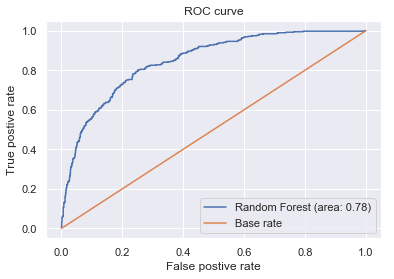

In [621]:
# ROC curve

fpr, tpr, thresold = metrics.roc_curve(feat_y_test, RF_model_final.predict_proba(feat_x_test)[:][:,1])

plt.plot(fpr,tpr , label = 'Random Forest (area: %0.2f)' % metrics.roc_auc_score(feat_y_test,predicted))
plt.plot([0,1],[0,1],label = 'Base rate')
plt.xlabel("False postive rate")
plt.ylabel("True postive rate")
plt.title("ROC curve")
plt.legend()

In [619]:
rf_result_1 = cross_val_score(RF_model_final, feat_x_train, feat_y_train,cv=5, scoring = 'accuracy')
print(rf_result_1.mean())

0.7555912441430352


In [620]:
rf_result_1

array([0.74622893, 0.77373558, 0.74889086, 0.75244011, 0.75666075])